# 02 Predicting Armed Conflict Using Protest Data - Analysis I / Transformations, Training, Predicting

Content:

Last updated: 08.09.2022

## Overview
* [Importing modules](#modules)
* [Defining folder structure](#define_folders)
* [Specifying global parameters](#specify_parameters)
* [Loading query sets](#load_queries)
* [Limiting geographical scope](#limit_geo)
* [Applying additional transformations](#transforms)
* [Training models](#training)

## Loading modules<a class="anchor" id="modules"></a>

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import geopandas as gpd

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Views 3
import viewser
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_dataviz.map import mapper, utils
from views_runs import storage
import views_transformation_library.splag4d as spl
from views_runs.storage import store, retrieve, fetch_metadata


from ingester3.config import source_db_path

# Additional transforms from views2
from views_transformation_library.views_2 import ln
from views_transformation_library.views_2 import moving_sum
from views_transformation_library.views_2 import greater_or_equal

# Additional transforms
import predicting_armed_conflict_using_protest_data_transforms as transforms
import predicting_armed_conflict_using_protest_data_models as organize 
import predicting_armed_conflict_using_protest_data_utils as utils 
import predicting_armed_conflict_using_protest_data_eval as evaltools


# Other packages
import pickle as pkl
from datetime import datetime
import sqlalchemy as sa
from patsy import dmatrices
import importlib
import os
import yaml

/Users/maxle647/miniconda3/envs/viewser/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/maxle647/miniconda3/envs/viewser/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/maxle647/miniconda3/envs/viewser/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
importlib.reload(transforms)
importlib.reload(organize)
importlib.reload(utils)
importlib.reload(evaltools)

<module 'predicting_armed_conflict_using_protest_data_eval' from '/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py'>

## Defining folder structure<a class="anchor" id="define_folders"></a>

In [91]:
if True:
    # Define path.
    folder_path = '/Users/maxle647/protest_views3'  # Change path
    print('Folder path:', folder_path)

    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    # Set up directory for output
    folder_path = os.path.join(folder_path, '{sub}')

    # Define output paths
    output_paths = {
        'descriptives': folder_path.format(sub=f'descriptives'),
        'evaluation': folder_path.format(sub=f'evaluation'),
        'summary_tables':folder_path.format(sub=f'summary_tables'),
        'predictions':folder_path.format(sub=f'predictions'),
        # Sub folders - ADD more sub_folders
        'scores_tables': os.path.join(folder_path.format(sub=f"evaluation"), "scores_tables"),
        'coord_plots': os.path.join(folder_path.format(sub=f"evaluation"), "coord_plots"),
        'bootstrapped': os.path.join(folder_path.format(sub=f"evaluation"), "bootstrapped")
        
    }

    # Create new folders if they do not already exist.
    for k, v in output_paths.items():
        if not os.path.isdir(v):
            os.makedirs(v)

Folder path: /Users/maxle647/protest_views3


## Specifying global parameters <a class="anchor" id="specify_parameters"></a>

In [4]:
# Specify for which outcome to run the notebook for. 
run_outcome = 'incidence' # or 'onset'
train = True

In [5]:
if run_outcome == 'incidence':
    fetchid_01 = 'protest_paper_0109_2022_incidence_01'
    fetchid_02 = 'protest_paper_0109_2022_incidence_02'
    fetchid_03_01 = 'protest_paper_0109_2022_incidence_03_01'
    fetchid_03_02 = 'protest_paper_0109_2022_incidence_03_02'
    depvar = 'ged_sb_dummy_dep'
    
if run_outcome == 'incidence_small':
    fetch_id = 'small_set_models_2909_incidence'
    depvar = 'ged_sb_dummy_dep'

if run_outcome == 'main_models_incidence':
    fetchid_01 = 'main_models_0810_2022_incidence_01'
    fetchid_02 = 'main_models_0810_2022_incidence_02'
    depvar = 'ged_sb_dummy_dep'
    

if run_outcome == 'baselines_only':
    fetch_id = 'baseline_incidence'
    depvar = 'ged_sb_dummy_dep'
        
if run_outcome == 'onset':
    fetchid_01 = 'protest_paper_0109_2022_onset_01'
    fetchid_02 = 'protest_paper_0109_2022_onset_02'
    fetchid_03_01 = 'protest_paper_0109_2022_onset_03_01'
    fetchid_03_02 = 'protest_paper_0109_2022_onset_03_02'
    depvar = 'ged_sb_dummy_on_dep'
    

## Loading query sets<a class="anchor" id="load_queries"></a>

In [6]:
# Fetch only baseline and simple protest models. 
if run_outcome == 'baselines_only':
    datasets = organize.FetchData(fetch_id)

In [7]:
# Fetch only baseline and simple protest models. 
if run_outcome == 'incidence_small':
    datasets = organize.FetchData(fetch_id)

In [8]:
# Fetch only baseline and simple protest models. 
if run_outcome == 'main_models_incidence':
    datasets_01 = organize.FetchData(fetchid_01)

In [9]:
# Fetch only baseline and simple protest models. 
if run_outcome == 'main_models_incidence':
    datasets_02 = organize.FetchData(fetchid_02)

In [10]:
# Fetch only baseline and simple protest models. 
if run_outcome == 'main_models_incidence':
    datasets_03 = []
    datasets_03.append(organize.MergeQueries(datasets_02[2]['df'],datasets_02[3]['df'],datasets_02[2]['Name']))
    datasets_03.append(datasets_02[0])
    datasets_03.append(datasets_02[1])

In [11]:
if run_outcome == 'main_models_incidence':
    datasets = datasets_01 + datasets_03

In [12]:
# Fetch datasets. Fetching breaks down if not split into three parts.
if run_outcome in ['onset','incidence']:
    datasets_01 = organize.FetchData(fetchid_01)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    baseline_simple: A dataset with 5 columns, with data between t = 1 and 852; 13110 units.
 .    econ_nat_bl: A dataset with 11 columns, with data between t = 1 and 852; 13110 units.
 .    econ_full_bl: A dataset with 16 columns, with data between t = 1 and 852; 13110 units.
 .    inst_elecdemo_bl: A dataset with 9 columns, with data between t = 1 and 852; 13110 units.
 .    inst_civlib_bl: A dataset with 11 columns, with data between t = 1 and 852; 13110 units.
 .    inst_elect_bl: A dataset with 13 columns, with data between t = 1 and 852; 13110 units.
 .    inst_devi_bl: A dataset with 29 columns, with data between t = 1 and 852; 13110 units.
 .    elect_econ_nat_bl: A dataset with 16 columns, with data between t = 1 and 852; 13110 units.
 .    elect_econ_full_bl: A dataset with 21 columns, with data between t = 1 and 852; 13110 units.
 .    devi_econ_nat_bl: A dataset with 32 columns, with data b

In [13]:
# Fetch datasets. Fetching breaks down if not split into three parts.
if run_outcome in ['onset','incidence']:
    datasets_02 = organize.FetchData(fetchid_02)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    pr_econ_nat_bl: A dataset with 33 columns, with data between t = 1 and 852; 13110 units.
 .    pr_econ_full_bl: A dataset with 37 columns, with data between t = 1 and 852; 13110 units.
 .    pr_elect_econ_nat_bl: A dataset with 38 columns, with data between t = 1 and 852; 13110 units.
 .    pr_elect_econ_full_bl: A dataset with 42 columns, with data between t = 1 and 852; 13110 units.


In [14]:
# Fetch datasets. Fetching breaks down if not split into three parts.
if run_outcome in ['onset','incidence']:
    datasets_03_01 = organize.FetchData(fetchid_03_01)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    pr_devi_bl: A dataset with 30 columns, with data between t = 1 and 852; 13110 units.
 .    pr_devi_econ_nat_bl: A dataset with 33 columns, with data between t = 1 and 852; 13110 units.
 .    pr_devi_econ_full_bl: A dataset with 28 columns, with data between t = 1 and 852; 13110 units.


In [15]:
# Fetch datasets. Fetching breaks down if not split into three parts.
if run_outcome in ['onset','incidence']:
    datasets_03_02 = organize.FetchData(fetchid_03_02)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    pr_devi_bl: A dataset with 20 columns, with data between t = 1 and 852; 13110 units.
 .    pr_devi_econ_nat_bl: A dataset with 20 columns, with data between t = 1 and 852; 13110 units.
 .    pr_devi_econ_full_bl: A dataset with 29 columns, with data between t = 1 and 852; 13110 units.


In [16]:
# Merge 03_01 and 03_02
if run_outcome in ['onset','incidence']:
    datasets_03 = []
    datasets_03.append(organize.MergeQueries(datasets_03_01[0]['df'],datasets_03_02[0]['df'],datasets_03_01[0]['Name']))

In [17]:
if run_outcome in ['onset','incidence']:
    datasets_03.append(organize.MergeQueries(datasets_03_01[1]['df'],datasets_03_02[1]['df'],datasets_03_01[1]['Name']))

In [18]:
if run_outcome in ['onset','incidence']:
    datasets_03.append(organize.MergeQueries(datasets_03_01[2]['df'],datasets_03_02[2]['df'],datasets_03_01[2]['Name']))

In [19]:
# Append lists of dictonaries. 
if run_outcome in ['onset','incidence']:
    datasets = datasets_01 + datasets_02 + datasets_03

In [20]:
# Check integrity of data sets.
for df in datasets:
    organize.data_integrity_check(df, depvar)

Drop duplicates baseline_simple
Checking for NaN/Null
WARNING - NaN/Null data detected in baseline_simple column decay_ts_12_ged_sb_dummy
Reordering columns in model econ_nat_bl
Drop duplicates econ_nat_bl
Checking for NaN/Null
Reordering columns in model econ_full_bl
Drop duplicates econ_full_bl
Checking for NaN/Null
Drop duplicates inst_elecdemo_bl
Checking for NaN/Null
Drop duplicates inst_civlib_bl
Checking for NaN/Null
Reordering columns in model inst_elect_bl
Drop duplicates inst_elect_bl
Checking for NaN/Null
Drop duplicates inst_devi_bl
Checking for NaN/Null
Reordering columns in model elect_econ_nat_bl
Drop duplicates elect_econ_nat_bl
Checking for NaN/Null
Reordering columns in model elect_econ_full_bl
Drop duplicates elect_econ_full_bl
Checking for NaN/Null
Reordering columns in model devi_econ_nat_bl
Drop duplicates devi_econ_nat_bl
Checking for NaN/Null
Reordering columns in model devi_econ_full_bl
Drop duplicates devi_econ_full_bl
Checking for NaN/Null
Reordering columns 

## Limiting geographical and temporal scope<a class="anchor" id="limit_geo"></a>

In [21]:
# Filter pg ids for africa only.
df_pg = organize.fetch_africa_ids()

for df in datasets:
    organize.crop_africa(df,df_pg)

 .    baseline_simple: A dataset with 5 columns, with data between t = 1 and 852; 10678 units.
econ_nat_bl: A dataset with 11 columns, with data between t = 1 and 852; 10678 units.
econ_full_bl: A dataset with 16 columns, with data between t = 1 and 852; 10678 units.
inst_elecdemo_bl: A dataset with 9 columns, with data between t = 1 and 852; 10678 units.
inst_civlib_bl: A dataset with 11 columns, with data between t = 1 and 852; 10678 units.
inst_elect_bl: A dataset with 13 columns, with data between t = 1 and 852; 10678 units.
inst_devi_bl: A dataset with 29 columns, with data between t = 1 and 852; 10678 units.
elect_econ_nat_bl: A dataset with 16 columns, with data between t = 1 and 852; 10678 units.
elect_econ_full_bl: A dataset with 21 columns, with data between t = 1 and 852; 10678 units.
devi_econ_nat_bl: A dataset with 32 columns, with data between t = 1 and 852; 10678 units.
devi_econ_full_bl: A dataset with 37 columns, with data between t = 1 and 852; 10678 units.
pr_naive_b

In [22]:
# Filter month ids
for df in datasets:
    print(df['Name'])
    df['df'] = organize.crop_months(df['df'],200,520)

baseline_simple
econ_nat_bl
econ_full_bl
inst_elecdemo_bl
inst_civlib_bl
inst_elect_bl
inst_devi_bl
elect_econ_nat_bl
elect_econ_full_bl
devi_econ_nat_bl
devi_econ_full_bl
pr_naive_bl
pr_dynamic_loc_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


In [23]:
for df in datasets:
    print(df['Name'])
    df['df'] = organize.reindex_df(df['df'])

baseline_simple
econ_nat_bl
econ_full_bl
inst_elecdemo_bl
inst_civlib_bl
inst_elect_bl
inst_devi_bl
elect_econ_nat_bl
elect_econ_full_bl
devi_econ_nat_bl
devi_econ_full_bl
pr_naive_bl
pr_dynamic_loc_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


In [24]:
for df in datasets:
    print(df['df'].isna().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


## Applying transformations<a class="anchor" id="transforms"></a>

### Full economic development, country level and subnational level

Apply transformation to all the models that include the full economic development features

In [25]:
input_var = 'pgd_gcp_mer'
transf_var = 'pgd_gcp_mer_pc'

In [26]:
# Apply transformation only to first df.

applied_to_df = []
apply_to_dfs = []

first = True
for df in datasets:
    if 'econ_full' in df['Name']:
        if first:
            print(df['Name'])
            applied_to_df.append(df)
            # Normalise.
            df['df'][f'{transf_var}'] = transforms.divide_by_pop(df['df'],f'{input_var}',10000)

            # Nat log.
            df['df'][f'ln_{transf_var}'] = ln(df['df'][f'{transf_var}'])

            if df['df'][f'ln_{transf_var}'].equals(df['df'][f'{transf_var}']) == True:
                print('Warning, check log transformation')

            # Drop variables from df. Keep population variable for the moment as it will be needed for additional transformations. 
            print('n cols before:', len(df['df'].columns))
            df['df'] = df['df'].drop(labels=[input_var,transf_var], axis=1)
            print('n cols after:', len(df['df'].columns))
            
            first = False
        else:
            print(df['Name'])
            apply_to_dfs.append(df)

econ_full_bl
n cols before: 18
n cols after: 16
elect_econ_full_bl
devi_econ_full_bl
pr_econ_full_bl
pr_elect_econ_full_bl
pr_devi_econ_full_bl


In [27]:
# Concat to other dfs.
for df in apply_to_dfs:
    print(df['Name'])
    df['df'] = pd.concat([df['df'],applied_to_df[0]['df']['ln_pgd_gcp_mer_pc']],axis=1)    

elect_econ_full_bl
devi_econ_full_bl
pr_econ_full_bl
pr_elect_econ_full_bl
pr_devi_econ_full_bl


### Protest models

#### All protest models

In [28]:
pr_naive_cat = ['']
pr_categories = ['ri','in','ex','pe']

##### Applying transforms to naive and dynamic local models

In [29]:
# Ln_protestcat_pop_tlag0

applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        
        if 'naive_bl' in df['Name']: 
            print(df['Name'])
        
            for pr in pr_naive_cat:

                # Normalise.
                print('normalise variable')
                df['df'][f'acled_pr{pr}_pop'] = transforms.divide_by_pop(df['df'],f'acled_pr{pr}_count',10000)

                # Nat log.
                df['df'][f'ln_acled_pr{pr}_pop_tlag0'] = ln(df['df'][f'acled_pr{pr}_pop'])

                if df['df'][f'ln_acled_pr{pr}_pop_tlag0'].equals(df['df'][f'acled_pr{pr}_pop']) == True:
                    print('Warning, check log transformation')
        else:
            if first:
                applied_to_df.append(df)
                
                for pr in pr_categories:
                    print(df['Name'])

                    # Normalise.
                    print('normalise variable')
                    df['df'][f'acled_pr{pr}_pop'] = transforms.divide_by_pop(df['df'],f'acled_pr{pr}_count',10000)

                    # Nat log.
                    df['df'][f'ln_acled_pr{pr}_pop_tlag0'] = ln(df['df'][f'acled_pr{pr}_pop'])

                    if df['df'][f'ln_acled_pr{pr}_pop_tlag0'].equals(df['df'][f'acled_pr{pr}_pop']) == True:
                        print('Warning, check log transformation')
                
                first = False
                
            else:
                print(df['Name'])
                apply_to_dfs.append(df)

pr_naive_bl
normalise variable
pr_dynamic_loc_bl
normalise variable
pr_dynamic_loc_bl
normalise variable
pr_dynamic_loc_bl
normalise variable
pr_dynamic_loc_bl
normalise variable
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


In [30]:
# Cumulative sum over three months (normalised) + nat. log.
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        print(df['Name'])
        
        if 'naive_bl' in df['Name']: 
        
            for pr in pr_naive_cat:
            
                # Cumulative sum
                print('compute cumulative sum')
                df['df'][f'cumsum_3_acled_pr{pr}_count'] = transforms.moving_sum(s=df['df'][f'acled_pr{pr}_count'], time=3)
                print('Negative values after applying cumulative sum:', df['df'][f'cumsum_3_acled_pr{pr}_count'].any()<0 == True)

                # Normalise.
                print('normalise variable')
                df['df'][f'cumsum_3_acled_pr{pr}_pop'] = transforms.divide_by_pop(df['df'],f'cumsum_3_acled_pr{pr}_count',10000)

                # Nat log.
                df['df'][f'ln_cumsum_3_acled_pr{pr}_pop'] = ln(df['df'][f'cumsum_3_acled_pr{pr}_pop'])
                if df['df'][f'ln_cumsum_3_acled_pr{pr}_pop'].equals(df['df'][f'cumsum_3_acled_pr{pr}_pop']) == True:
                    print('Warning, check log transformation') 
                else:
                    print('Ok')
        else:
            if first:
                applied_to_df.append(df)
                
                for pr in pr_categories:

                    # Cumulative sum
                    print('compute cumulative sum')
                    df['df'][f'cumsum_3_acled_pr{pr}_count'] = transforms.moving_sum(s=df['df'][f'acled_pr{pr}_count'], time=3)
                    print('Negative values after applying cumulative sum:', df['df'][f'cumsum_3_acled_pr{pr}_count'].any()<0 == True)

                    # Normalise.
                    print('normalise variable')
                    df['df'][f'cumsum_3_acled_pr{pr}_pop'] = transforms.divide_by_pop(df['df'],f'cumsum_3_acled_pr{pr}_count',10000)

                    # Nat log.
                    df['df'][f'ln_cumsum_3_acled_pr{pr}_pop'] = ln(df['df'][f'cumsum_3_acled_pr{pr}_pop'])
                    if df['df'][f'ln_cumsum_3_acled_pr{pr}_pop'].equals(df['df'][f'cumsum_3_acled_pr{pr}_pop']) == True:
                        print('Warning, check log transformation')
                    else:
                        print('Ok')
                
                first = False
            
            else:
                print(df['Name'])
                apply_to_dfs.append(df)
print('DONE')

pr_naive_bl
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
Ok
pr_dynamic_loc_bl
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
Ok
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
Ok
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
Ok
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
Ok
pr_dynamic_nat_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_elecdemo_bl
pr_civlib_bl
pr_civlib_bl
pr_elect_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl
pr_devi_econ_full_bl
DONE


In [31]:
# Splag, normalised by population
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        print(df['Name'])
        
        if 'naive_bl' in df['Name']: 
        
            for pr in pr_naive_cat:

                # Splag.
                print('take splag of normalised variable')
                df['df'][f'splag_1_2_acled_pr{pr}_pop'] = spl.get_splag4d(pd.DataFrame(df['df'][f'acled_pr{pr}_pop']),True,1,2,0,0).fillna(0)

                # Nat log.
                df['df'][f'ln_splag_1_2_acled_pr{pr}_pop_tlag0'] = ln(df['df'][f'splag_1_2_acled_pr{pr}_pop'])
                if df['df'][f'ln_splag_1_2_acled_pr{pr}_pop_tlag0'].equals(df['df'][f'splag_1_2_acled_pr{pr}_pop']) == True:
                    print('Warning, check log transformation') 
                else:
                    print('Ok')
                    
        else:
            if first:
                applied_to_df.append(df)
                
                for pr in pr_categories:
                
                    # Splag.
                    print('take splag of normalised variable')
                    df['df'][f'splag_1_2_acled_pr{pr}_pop'] = spl.get_splag4d(pd.DataFrame(df['df'][f'acled_pr{pr}_pop']),True,1,2,0,0).fillna(0)

                    # Nat log.
                    df['df'][f'ln_splag_1_2_acled_pr{pr}_pop_tlag0'] = ln(df['df'][f'splag_1_2_acled_pr{pr}_pop'])
                    if df['df'][f'ln_splag_1_2_acled_pr{pr}_pop_tlag0'].equals(df['df'][f'splag_1_2_acled_pr{pr}_pop']) == True:
                        print('Warning, check log transformation') 
                    else:
                        print('Ok')
                
                first = False
            
            else:
                print(df['Name'])
                apply_to_dfs.append(df)
print('DONE')

pr_naive_bl
take splag of normalised variable
Ok
pr_dynamic_loc_bl
take splag of normalised variable
Ok
take splag of normalised variable
Ok
take splag of normalised variable
Ok
take splag of normalised variable
Ok
pr_dynamic_nat_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_elecdemo_bl
pr_civlib_bl
pr_civlib_bl
pr_elect_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl
pr_devi_econ_full_bl
DONE


In [32]:
# Cumulative sum of splag, normalised by population
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        print(df['Name'])
        
        if 'naive_bl' in df['Name']: 
        
            for pr in pr_naive_cat:

                # Splag.
                print('take splag of normalised variable')
                df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop'] = spl.get_splag4d(pd.DataFrame(df['df'][f'cumsum_3_acled_pr{pr}_pop']),True,1,2,0,0).fillna(0)

                # Nat log.
                df['df'][f'ln_splag_1_2_cumsum_3_acled_pr{pr}_pop'] = ln(df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop'])
                if df['df'][f'ln_splag_1_2_cumsum_3_acled_pr{pr}_pop'].equals(df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop']) == True:
                    print('Warning, check log transformation') 
                else:
                    print('Ok')
                    
        else:
            if first:
                applied_to_df.append(df)
                
                for pr in pr_categories:
                    
                    # Splag.
                    print('take splag of normalised variable')
                    df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop'] = spl.get_splag4d(pd.DataFrame(df['df'][f'cumsum_3_acled_pr{pr}_pop']),True,1,2,0,0).fillna(0)

                    # Nat log.
                    df['df'][f'ln_splag_1_2_cumsum_3_acled_pr{pr}_pop'] = ln(df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop'])
                    if df['df'][f'ln_splag_1_2_cumsum_3_acled_pr{pr}_pop'].equals(df['df'][f'splag_1_2_cumsum_3_acled_pr{pr}_pop']) == True:
                        print('Warning, check log transformation') 
                    else:
                        print('Ok')
                
                first = False
            
            else:
                print(df['Name'])
                apply_to_dfs.append(df)
print('DONE')

pr_naive_bl
take splag of normalised variable
Ok
pr_dynamic_loc_bl
take splag of normalised variable
Ok
take splag of normalised variable
Ok
take splag of normalised variable
Ok
take splag of normalised variable
Ok
pr_dynamic_nat_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_elecdemo_bl
pr_civlib_bl
pr_civlib_bl
pr_elect_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl
pr_devi_econ_full_bl
DONE


In [33]:
# Fetch gdf
gdf = organize.fetch_gdf()

 .    

In [34]:
# Make sure indices are equal
idx1 = gdf.index 
idx2 = datasets[1]['df'].index
idx1.equals(idx2)

True

In [35]:
# Concat with dataframes
for df in datasets:
    print(df['Name'])
    df['df'] = pd.concat([df['df'],gdf],axis=1)    

baseline_simple
econ_nat_bl
econ_full_bl
inst_elecdemo_bl
inst_civlib_bl
inst_elect_bl
inst_devi_bl
elect_econ_nat_bl
elect_econ_full_bl
devi_econ_nat_bl
devi_econ_full_bl
pr_naive_bl
pr_dynamic_loc_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


In [36]:
# Minimum distance to closest protset event over three months.
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        print(df['Name'])
        
        if 'naive_bl' in df['Name']: 
        
            for pr in pr_naive_cat:

                # Get dummy variable.
                print('get dummy')
                df['df'][f'acled_pr{pr}_dummy'] = greater_or_equal(df['df'][f'acled_pr{pr}_count'],1)

                # Compute distance.
                print('compute distance')
                df['df'][f'dist_acled_pr{pr}_dummy'] = transforms.distance_to_event(df=df['df'],col=f'acled_pr{pr}_dummy',k=1,fill_value=99)

                # Get minimum distance over three months.
                print('get minimum distance')
                df['df'][f'min_dist_acled_pr{pr}_dummy'] = transforms.moving_min(s=df['df'][f'dist_acled_pr{pr}_dummy'],t=3)

                # Nat log.
                df['df'][f'ln_min_dist_3_acled_pr{pr}'] = ln(df['df'][f'min_dist_acled_pr{pr}_dummy'])

                if df['df'][f'ln_min_dist_3_acled_pr{pr}'].equals(df['df'][f'min_dist_acled_pr{pr}_dummy']) == True:
                    print('Warning, check log transformation')
                else:
                    print('Ok')
                    
        else:
            if first:
                applied_to_df.append(df)
                
                for pr in pr_categories:
                    
                    # Get dummy variable.
                    print('get dummy')
                    df['df'][f'acled_pr{pr}_dummy'] = greater_or_equal(df['df'][f'acled_pr{pr}_count'],1)

                    # Compute distance.
                    print('compute distance')
                    df['df'][f'dist_acled_pr{pr}_dummy'] = transforms.distance_to_event(df=df['df'],col=f'acled_pr{pr}_dummy',k=1,fill_value=99)

                    # Get minimum distance over three months.
                    print('get minimum distance')
                    df['df'][f'min_dist_acled_pr{pr}_dummy'] = transforms.moving_min(s=df['df'][f'dist_acled_pr{pr}_dummy'],t=3)

                    # Nat log.
                    df['df'][f'ln_min_dist_3_acled_pr{pr}'] = ln(df['df'][f'min_dist_acled_pr{pr}_dummy'])

                    if df['df'][f'ln_min_dist_3_acled_pr{pr}'].equals(df['df'][f'min_dist_acled_pr{pr}_dummy']) == True:
                        print('Warning, check log transformation')
                    else:
                        print('Ok')
                
                first = False
            
            else:
                print(df['Name'])
                apply_to_dfs.append(df)
print('DONE')

pr_naive_bl
get dummy
compute distance


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.geometry.centroid.x
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.geometry.centroid.y
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list(zip(gdf.loc[times[0]].centroid.x, gdf.loc[times[0]].centroid.y))
/Users/maxle647/Views3/predicting_armed_c

get minimum distance
Ok
pr_dynamic_loc_bl
get dummy
compute distance


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.geometry.centroid.x
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.geometry.centroid.y
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list(zip(gdf.loc[times[0]].centroid.x, gdf.loc[times[0]].centroid.y))
/Users/maxle647/Views3/predicting_armed_c

get minimum distance
Ok
get dummy
compute distance


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.geometry.centroid.x
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.geometry.centroid.y
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list(zip(gdf.loc[times[0]].centroid.x, gdf.loc[times[0]].centroid.y))
/Users/maxle647/Views3/predicting_armed_c

get minimum distance
Ok
get dummy
compute distance


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.geometry.centroid.x
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.geometry.centroid.y
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list(zip(gdf.loc[times[0]].centroid.x, gdf.loc[times[0]].centroid.y))
/Users/maxle647/Views3/predicting_armed_c

get minimum distance
Ok
get dummy
compute distance


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.geometry.centroid.x
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.geometry.centroid.y
/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_transforms.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list(zip(gdf.loc[times[0]].centroid.x, gdf.loc[times[0]].centroid.y))
/Users/maxle647/Views3/predicting_armed_c

get minimum distance
Ok
pr_dynamic_nat_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_elecdemo_bl
pr_civlib_bl
pr_civlib_bl
pr_elect_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl
pr_devi_econ_full_bl
DONE


##### Adding transforms to remaining protest models

In [37]:
feats_concat_pr = []
for pr in pr_categories:
    feats_concat_pr.append(f'decay_ts_6_acled_pr{pr}_dummy')
    feats_concat_pr.append(f'ln_acled_pr{pr}_pop_tlag0')
    feats_concat_pr.append(f'ln_cumsum_3_acled_pr{pr}_pop')
    feats_concat_pr.append(f'decay_ts_6_splag_1_2_acled_pr{pr}_dummy')
    feats_concat_pr.append(f'ln_splag_1_2_acled_pr{pr}_pop_tlag0')
    feats_concat_pr.append(f'ln_splag_1_2_cumsum_3_acled_pr{pr}_pop')
    feats_concat_pr.append(f'ln_min_dist_3_acled_pr{pr}')
feats_concat_pr

['decay_ts_6_acled_prri_dummy',
 'ln_acled_prri_pop_tlag0',
 'ln_cumsum_3_acled_prri_pop',
 'decay_ts_6_splag_1_2_acled_prri_dummy',
 'ln_splag_1_2_acled_prri_pop_tlag0',
 'ln_splag_1_2_cumsum_3_acled_prri_pop',
 'ln_min_dist_3_acled_prri',
 'decay_ts_6_acled_prin_dummy',
 'ln_acled_prin_pop_tlag0',
 'ln_cumsum_3_acled_prin_pop',
 'decay_ts_6_splag_1_2_acled_prin_dummy',
 'ln_splag_1_2_acled_prin_pop_tlag0',
 'ln_splag_1_2_cumsum_3_acled_prin_pop',
 'ln_min_dist_3_acled_prin',
 'decay_ts_6_acled_prex_dummy',
 'ln_acled_prex_pop_tlag0',
 'ln_cumsum_3_acled_prex_pop',
 'decay_ts_6_splag_1_2_acled_prex_dummy',
 'ln_splag_1_2_acled_prex_pop_tlag0',
 'ln_splag_1_2_cumsum_3_acled_prex_pop',
 'ln_min_dist_3_acled_prex',
 'decay_ts_6_acled_prpe_dummy',
 'ln_acled_prpe_pop_tlag0',
 'ln_cumsum_3_acled_prpe_pop',
 'decay_ts_6_splag_1_2_acled_prpe_dummy',
 'ln_splag_1_2_acled_prpe_pop_tlag0',
 'ln_splag_1_2_cumsum_3_acled_prpe_pop',
 'ln_min_dist_3_acled_prpe']

In [38]:
# Concat to other dfs.
for df in apply_to_dfs:
    print(df['Name'])
    df['df'] = pd.concat([df['df'],applied_to_df[0]['df'][feats_concat_pr]],axis=1)

pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


#### All models besides local dynamic and naive protest model

##### Applying transforms to dynamic local + national models

In [39]:
# Ln_protestcat_pop_cm_tlag0
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        if df['Name'] not in ['pr_naive_bl','pr_dynamic_loc_bl']:
            if first:
                applied_to_df.append(df)
                print(df['Name'])

                for pr in pr_categories:
                    print(pr)

                    # Normalise.
                    print('normalise variable')
                    df['df'][f'acled_pr{pr}_pop_cm'] = transforms.divide_by_pop_cm(df['df'],f'acled_pr{pr}_count',10000)

                    # Nat log.
                    df['df'][f'ln_acled_pr{pr}_pop_cm_tlag0'] = ln(df['df'][f'acled_pr{pr}_pop_cm'])

                    if df['df'][f'ln_acled_pr{pr}_pop_cm_tlag0'].equals(df['df'][f'acled_pr{pr}_pop_cm']) == True:
                        print('Warning, check log transformation')
                    else:
                        print('OK')
                        
                first = False
                
            else:
                apply_to_dfs.append(df)

pr_dynamic_nat_bl
ri
normalise variable
OK
in
normalise variable
OK
ex
normalise variable
OK
pe
normalise variable
OK


In [40]:
# Ln_cumsum3_pop_cm_tlag0
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'pr' in df['Name']:
        if df['Name'] not in ['pr_naive_bl','pr_dynamic_loc_bl']:
            if first:
                applied_to_df.append(df)
                print(df['Name'])

                for pr in pr_categories:
                    print(pr)

                    # Cumulative sum
                    print('compute cumulative sum')
                    df['df'][f'cumsum_3_acled_pr{pr}_count_cm'] = transforms.moving_sum(s=df['df'][f'acled_pr{pr}_count_cm'], time=3)
                    print('Negative values after applying cumulative sum:', df['df'][f'cumsum_3_acled_pr{pr}_count_cm'].any()<0 == True)

                    # Normalise.
                    print('normalise variable')
                    df['df'][f'cumsum_3_acled_pr{pr}_pop_cm'] = transforms.divide_by_pop_cm(df['df'],f'cumsum_3_acled_pr{pr}_count_cm',10000)

                    # Nat log.
                    df['df'][f'ln_cumsum_3_acled_pr{pr}_pop_cm'] = ln(df['df'][f'cumsum_3_acled_pr{pr}_pop_cm'])
                    if df['df'][f'ln_cumsum_3_acled_pr{pr}_pop_cm'].equals(df['df'][f'cumsum_3_acled_pr{pr}_pop_cm']) == True:
                        print('Warning, check log transformation') 
                    else:
                            print('OK')
                        
                first = False
                
            else:
                apply_to_dfs.append(df)

pr_dynamic_nat_bl
ri
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
OK
in
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
OK
ex
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
OK
pe
compute cumulative sum
Negative values after applying cumulative sum: False
normalise variable
OK


##### Adding transforms to remaining protest models

In [41]:
feats_concat_pr = []
for pr in pr_categories:
    feats_concat_pr.append(f'decay_ts_6_acled_pr{pr}_dummy_cm')
    feats_concat_pr.append(f'ln_acled_pr{pr}_pop_cm_tlag0')
    feats_concat_pr.append(f'ln_cumsum_3_acled_pr{pr}_pop_cm')
feats_concat_pr

['decay_ts_6_acled_prri_dummy_cm',
 'ln_acled_prri_pop_cm_tlag0',
 'ln_cumsum_3_acled_prri_pop_cm',
 'decay_ts_6_acled_prin_dummy_cm',
 'ln_acled_prin_pop_cm_tlag0',
 'ln_cumsum_3_acled_prin_pop_cm',
 'decay_ts_6_acled_prex_dummy_cm',
 'ln_acled_prex_pop_cm_tlag0',
 'ln_cumsum_3_acled_prex_pop_cm',
 'decay_ts_6_acled_prpe_dummy_cm',
 'ln_acled_prpe_pop_cm_tlag0',
 'ln_cumsum_3_acled_prpe_pop_cm']

In [42]:
# Concat to other dfs.
for df in apply_to_dfs:
    print(df['Name'])
    df['df'] = pd.concat([df['df'],applied_to_df[0]['df'][feats_concat_pr]],axis=1)

pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


## Descriptives

In [43]:
# Descriptive statistics for dependent variable.
save_table = False
add_protest = False

descr_start = [205,445]
descr_end = 480
cols = ['ged_sb_dummy_dep']
    
# Write to tex.
if save_table:
    for time in descr_start:
        tex = datasets[0]['df'].loc[time:descr_end][cols].describe().round(3).to_latex(index=True)
        now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        meta = f"""
        %Output created by protest_paper.ipynb.
        %Descriptive Statistics.
        %Produced on {now}.
        \\
        """
        tex = meta + tex
        path_out = os.path.join(output_paths['descriptives'], f"descr_ged_dummy_sb_{time}_{descr_end}.txt")
        with open(path_out, "w") as f:
            f.write(tex)
        print(f"Written to {path_out}.")

for time in descr_start:
    print(datasets[0]['df'].loc[time:descr_end][cols].describe().round(3))

       ged_sb_dummy_dep
count       2947128.000
mean              0.003
std               0.052
min               0.000
25%               0.000
50%               0.000
75%               0.000
max               1.000
       ged_sb_dummy_dep
count        384408.000
mean              0.005
std               0.072
min               0.000
25%               0.000
50%               0.000
75%               0.000
max               1.000


## Add step-shifted outcome

In [44]:
# Parameters
steps = [3,6,12,36] #[*range(1, 36+1, 1)] # Which steps to train and predict for

# Add 'step-shifted' Outcome
for df in datasets:
    for step in steps:
        df['df'][f'{depvar}_step{step}'] = df['df'][depvar].groupby(level=1).shift(-step)

## Implementing Downsampling

### Political instiutions models (IV)

As discussed in the theoretical section,
protests are more common and widely accepted as political behavior in democracies than
in non-democracies. To capture this, we include the residuals from a fitted negative
binomial regression model with the count of protest with excessive violence events as the
dependent variables as a proxy for an unexpected amount of protests.1

Steps:
- estimate a model with peacful protests as DV 
- save residuals from model, i.e. the remaining variation in peacful protests that can not be explaiend by the variables included in our regression
- estimate a second model with protests with excessive violence as DV
- save fitted values from model

In [45]:
applied_to_df = []
apply_to_dfs = []

first = True

for df in datasets:
    if 'devi' in df['Name']:
        if first:
            applied_to_df.append(df)
            first = False

        else:
            apply_to_dfs.append(df)

df_inst_devi_bl_raw = applied_to_df[0]['df']
df_inst_devi_bl_raw

ged_sb_dummy_dep  ged_sb_dummy  ln_ged_sb  \
month_id priogrid_gid                                              
200      62356                        0             0        0.0   
         79599                        0             0        0.0   
         79600                        0             0        0.0   
         79601                        0             0        0.0   
         80317                        0             0        0.0   
...                                 ...           ...        ...   
520      183259                       0             0        0.0   
         183260                       0             0        0.0   
         183261                       0             0        0.0   
         183262                       0             0        0.0   
         183263                       0             0        0.0   

                       acled_prpe_count  acled_prex_count  \
month_id priogrid_gid                                       
200      62356                      0.0               0.0   
         79599                      0.0               0.0   
         79600                      0.0               0.0   
         79601                      0.0               0.0   
         80317                      0.0               0.0   
...                                 ...               ...   
520      183259                     0.0               0.0   
         183260                     0.0               0.0   
         183261                     0.0               0.0   
         183262                     0.0               0.0   
         183263                     0.0               0.0   

                       vdem_v2x_polyarchy_tlag12  vdem_v2x_civlib_tlag12  \
month_id priogrid_gid                                                      
200      62356                             0.664                   0.854   
         79599                             0.664                   0.854   
         79600                             0.664                   0.854   
         79601                             0.664                   0.854   
         80317                             0.664                   0.854   
...                                          ...                     ...   
520      183259                            0.556                   0.805   
         183260                            0.556                   0.805   
         183261                            0.556                   0.805   
         183262                            0.556                   0.805   
         183263                            0.556                   0.805   

                       pgd_pop_gpw_sum  mov_avg_12_ged_best_sb  \
month_id priogrid_gid                                            
200      62356                  0.0000                     0.0   
         79599               5473.9917                     0.0   
         79600               3153.7246                     0.0   
         79601              14486.7580                     0.0   
         80317             277324.2500                     0.0   
...                                ...                     ...   
520      183259            161971.7300                     0.0   
         183260            228357.9800                     0.0   
         183261            151442.9800                     0.0   
         183262             12295.8660                     0.0   
         183263             12391.9650                     0.0   

                       acled_prpe_count_tlag1  ...  \
month_id priogrid_gid                          ...   
200      62356                            0.0  ...   
         79599                            0.0  ...   
         79600                            0.0  ...   
         79601                            0.0  ...   
         80317                            0.0  ...   
...                                       ...  ...   
520      183259                           0.0  ...   
         1

#### Estimating peaceful protests - extracting residuals

In [46]:
# Set up regression expressions
expr_peace = """acled_prpe_count ~ 
vdem_v2x_polyarchy_tlag12 + 
vdem_v2x_civlib_tlag12 + 
ln_acled_prpe_count_tlag1 + 
ln_acled_prex_count_tlag1 +
ln_geb_sb_best_tlag1 +
ln_geb_os_best_tlag1 +
ln_splag_1_1_ged_sb_best_tlag1 +
ln_splag_1_1_ged_os_best_tlag1 +
ln_splag_1_2_acled_prpe_count_tlag1 +
ln_splag_1_2_acled_prex_count_tlag1 +
pgd_pop_gpw_sum 
"""

In [47]:
# Fit poission.
y_deviant, X_deviant = dmatrices(expr_peace, df_inst_devi_bl_raw.loc[205:444], return_type='dataframe')
poi_results = sm.GLM(y_deviant, X_deviant, family=sm.families.Poisson()).fit()
print(poi_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       acled_prpe_count   No. Observations:              2562720
Model:                            GLM   Df Residuals:                  2562708
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88431.
Date:                Mon, 10 Oct 2022   Deviance:                   1.5164e+05
Time:                        23:35:19   Pearson chi2:                 3.66e+06
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [48]:
# Check for overdispersion

def ct_response(row):
    "Calculate response observation for Cameron-Trivedi dispersion test"
    y = row['acled_prpe_count']
    m = row['bev_mu']
    return ((y - m)**2 - y) / m

ct_data = df_inst_devi_bl_raw.loc[205:444].copy()
ct_data['bev_mu'] = poi_results.mu
ct_data['ct_resp'] = ct_data.apply(ct_response, axis=1)

# Linear regression of auxiliary formula
ct_results = smf.ols('ct_resp ~ bev_mu - 1', ct_data).fit()
# Construct confidence interval for alpha, the coefficient of bev_mu
# Overdispersion corresponds to alpha > 0 
alpha_ci95 = ct_results.conf_int(0.05).loc['bev_mu']
print('\nC-T dispersion test: alpha = {:5.3f}, 95% CI = ({:5.3f}, {:5.3f})'
        .format(ct_results.params[0], alpha_ci95.loc[0], alpha_ci95.loc[1]))


C-T dispersion test: alpha = 0.761, 95% CI = (0.438, 1.084)


In [49]:
# Fit NB.
y_deviant, X_deviant = dmatrices(expr_peace, df_inst_devi_bl_raw.loc[205:444], return_type='dataframe')
nb_results = sm.GLM(y_deviant, X_deviant, family=sm.families.NegativeBinomial(alpha=ct_results.params[0])).fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       acled_prpe_count   No. Observations:              2562720
Model:                            GLM   Df Residuals:                  2562708
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72857.
Date:                Mon, 10 Oct 2022   Deviance:                   1.1144e+05
Time:                        23:36:32   Pearson chi2:                 3.16e+06
No. Iterations:                    34                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [50]:
# Likelihood Ratio test whether Poission or NB is better suited. 
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

llf = poi_results.llf
llflitter = nb_results.llf

# Suggest that nb is better fitted
lr, p = lrtest(llf, llflitter)
print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

LR test, p value: 31147.57, 0.0000


In [51]:
# Save residuals.
df_inst_devi_bl_raw['inst_resid_prpe'] = nb_results.resid_response
df_inst_devi_bl_raw['inst_resid_prpe'] = df_inst_devi_bl_raw['inst_resid_prpe'].fillna(0)

In [52]:
# Write to text file.
with open('prpe_nb_summary_091022.txt', 'w') as fh:
    fh.write(nb_results.summary().as_text())

#### Estimating protests with excessive violence - extracting fitted values

In [53]:
# Set up regression expressions
expr_exvio = """acled_prex_count ~ 
vdem_v2x_polyarchy_tlag12 + 
vdem_v2x_civlib_tlag12 + 
ln_acled_prpe_count_tlag1 + 
ln_acled_prex_count_tlag1 +
ln_geb_sb_best_tlag1 +
ln_geb_os_best_tlag1 +
ln_splag_1_1_ged_sb_best_tlag1 +
ln_splag_1_1_ged_os_best_tlag1 +
ln_splag_1_2_acled_prpe_count_tlag1 +
ln_splag_1_2_acled_prex_count_tlag1 +
pgd_pop_gpw_sum 
"""

In [54]:
# Fit poission to get alpha.
y_deviant, X_deviant = dmatrices(expr_exvio, df_inst_devi_bl_raw.loc[205:444], return_type='dataframe')
poi_results2 = sm.GLM(y_deviant, X_deviant, family=sm.families.Poisson()).fit()
print(poi_results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       acled_prex_count   No. Observations:              2562720
Model:                            GLM   Df Residuals:                  2562708
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9212.2
Date:                Mon, 10 Oct 2022   Deviance:                       16396.
Time:                        23:36:53   Pearson chi2:                 2.87e+06
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [55]:
# Check for overdispersion
import statsmodels.formula.api as smf
def ct_response(row):
    "Calculate response observation for Cameron-Trivedi dispersion test"
    y = row['acled_prex_count']
    m = row['bev_mu']
    return ((y - m)**2 - y) / m

ct_data = df_inst_devi_bl_raw.loc[205:444].copy()
ct_data['bev_mu'] = poi_results2.mu
ct_data['ct_resp'] = ct_data.apply(ct_response, axis=1)

# Linear regression of auxiliary formula
ct_results = smf.ols('ct_resp ~ bev_mu - 1', ct_data).fit()
# Construct confidence interval for alpha, the coefficient of bev_mu
# Overdispersion corresponds to alpha > 0 
alpha_ci95 = ct_results.conf_int(0.05).loc['bev_mu']
print('\nC-T dispersion test: alpha = {:5.3f}, 95% CI = ({:5.3f}, {:5.3f})'
        .format(ct_results.params[0], alpha_ci95.loc[0], alpha_ci95.loc[1]))


C-T dispersion test: alpha = 1.197, 95% CI = (-9.341, 11.735)


In [56]:
# Fit negative binomial.
y_deviant, X_deviant = dmatrices(expr_exvio, df_inst_devi_bl_raw.loc[205:444], return_type='dataframe')
nb2_results = sm.GLM(y_deviant, X_deviant,family=sm.families.NegativeBinomial(alpha=ct_results.params[0])).fit()
print(nb2_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       acled_prex_count   No. Observations:              2562720
Model:                            GLM   Df Residuals:                  2562708
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8453.3
Date:                Mon, 10 Oct 2022   Deviance:                       13923.
Time:                        23:38:07   Pearson chi2:                 2.72e+06
No. Iterations:                    36                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [57]:
# Save fitted values.
df_inst_devi_bl_raw['inst_yhat_prex'] = nb2_results.fittedvalues
df_inst_devi_bl_raw['inst_yhat_prex'] = df_inst_devi_bl_raw['inst_yhat_prex'].fillna(0)

In [58]:
# Write to text file.
with open('prex_nb_summary_101022.txt', 'w') as fh:
    fh.write(nb2_results.summary().as_text())

#### Specification of deviation model: Baseline + residuals and fitted values

In [59]:
# Add feature to every table including the deviation model.
for df in apply_to_dfs:
    print('Name')
    if 'devi' in df['Name']:
        print('n cols before:', len(df['df'].columns))
        df['df'] = pd.concat([df['df'],df_inst_devi_bl_raw['inst_yhat_prex'],df_inst_devi_bl_raw['inst_resid_prpe']],axis=1)
        print('n cols after:', len(df['df'].columns))

Name
n cols before: 37
n cols after: 39
Name
n cols before: 43
n cols after: 45
Name
n cols before: 93
n cols after: 95
Name
n cols before: 96
n cols after: 98
Name
n cols before: 101
n cols after: 103


## Filter only relevant features

In [60]:
# Read feature list.
with open('featlist_protest_paper_091022.yaml', 'r') as file:
    full_featlist = yaml.safe_load(file)

In [61]:
depvars_shifted = []
for step in steps:
    depvars_shifted.append(f'{depvar}_step{step}')
    
depvars_shifted

['ged_sb_dummy_dep_step3',
 'ged_sb_dummy_dep_step6',
 'ged_sb_dummy_dep_step12',
 'ged_sb_dummy_dep_step36']

In [62]:
for df in datasets:
    for feats,colname in zip(full_featlist.keys(),full_featlist.values()):
        if df['Name'] == feats:
            #depvars_shifted = depvars_shifted.append(colname)
            print('n cols before:', len(df['df'].columns))
            df['df'] = df['df'][colname+depvars_shifted]
            print('n cols after:', len(df['df'].columns))
            print(len(df['df'].columns), len(colname+depvars_shifted))

n cols before: 10
n cols after: 9
9 9
n cols before: 16
n cols after: 15
15 15
n cols before: 21
n cols after: 19
19 19
n cols before: 14
n cols after: 13
13 13
n cols before: 16
n cols after: 15
15 15
n cols before: 18
n cols after: 17
17 17
n cols before: 36
n cols after: 14
14 14
n cols before: 21
n cols after: 20
20 20
n cols before: 27
n cols after: 24
24 24
n cols before: 39
n cols after: 17
17 17
n cols before: 45
n cols after: 21
21 21
n cols before: 30
n cols after: 19
19 19
n cols before: 78
n cols after: 40
40 40
n cols before: 83
n cols after: 60
60 52
n cols before: 76
n cols after: 65
65 53
n cols before: 78
n cols after: 67
67 55
n cols before: 80
n cols after: 69
69 57
n cols before: 78
n cols after: 67
67 55
n cols before: 83
n cols after: 71
71 59
n cols before: 83
n cols after: 72
72 60
n cols before: 88
n cols after: 76
76 64
n cols before: 95
n cols after: 66
66 54
n cols before: 98
n cols after: 69
69 57
n cols before: 103
n cols after: 73
73 61


In [63]:
# Drop duplicated columns
for df in datasets:
    df['df'] = organize.getDuplicateColumns(df['df'])
    print(len(df['df'].columns))

9
15
19
13
15
17
14
20
24
17
21
19
40
Duplicates detected
Remove duplicates
52
Duplicates detected
Remove duplicates
53
Duplicates detected
Remove duplicates
55
Duplicates detected
Remove duplicates
57
Duplicates detected
Remove duplicates
55
Duplicates detected
Remove duplicates
59
Duplicates detected
Remove duplicates
60
Duplicates detected
Remove duplicates
64
Duplicates detected
Remove duplicates
54
Duplicates detected
Remove duplicates
57
Duplicates detected
Remove duplicates
61


In [64]:
if datasets[4]['df'].columns.duplicated().any() == True:
        print('Duplicates detected')

## Define Regressors

In [65]:
nj=14
n_estimators=500

rf_classifier = RandomForestClassifier(n_jobs=nj, n_estimators=n_estimators, random_state=1308)

In [66]:
for df in datasets:
    print(df['Name'])

baseline_simple
econ_nat_bl
econ_full_bl
inst_elecdemo_bl
inst_civlib_bl
inst_elect_bl
inst_devi_bl
elect_econ_nat_bl
elect_econ_full_bl
devi_econ_nat_bl
devi_econ_full_bl
pr_naive_bl
pr_dynamic_loc_bl
pr_dynamic_nat_bl
pr_elecdemo_bl
pr_civlib_bl
pr_elect_bl
pr_econ_nat_bl
pr_econ_full_bl
pr_elect_econ_nat_bl
pr_elect_econ_full_bl
pr_devi_bl
pr_devi_econ_nat_bl
pr_devi_econ_full_bl


## Specify Models

In [69]:
if True:
    ModelList = []

    model = {
        'modelname': f'protest_baseline_simple_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset': f'protest_paper_old_baseline_{run_outcome}',
        'data_train': 'baseline_simple'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_econ_nat_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_econ_national_bl',
        'data_train': 'econ_nat_bl'

    }
    ModelList.append(model)
    
    model = {
        'modelname': f'protest_econ_full_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_econ_full_bl',
        'data_train': 'econ_full_bl'

    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_inst_elecdemo_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_inst_elecdemo_bl',
        'data_train': 'inst_elecdemo_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_inst_civlib_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_inst_civlib_bl',
        'data_train': 'inst_civlib_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_inst_elect_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_inst_elect_bl',
        'data_train': 'inst_elect_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_inst_devi_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_devi_elect_bl',
        'data_train': 'inst_devi_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_naive_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_naive_bl',
        'data_train': 'pr_naive_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_dynamic_loc_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_dynamic_local_bl',
        'data_train': 'pr_dynamic_loc_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_dynamic_nat_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_dynamic_national_bl',
        'data_train': 'pr_dynamic_nat_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_elecdemo_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_elecdemo_bl',
        'data_train': 'pr_elecdemo_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_civlib_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_civlib_bl',
        'data_train': 'pr_civlib_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_elect_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_elect_bl',
        'data_train': 'pr_elect_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_devi_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_devi_bl',
        'data_train': 'pr_devi_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_econ_nat_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_econ_national_bl',
        'data_train': 'pr_econ_nat_bl'
    }
    ModelList.append(model)

    model = {
        'modelname': f'protest_pr_econ_full_bl_{run_outcome}',
        'algorithm': rf_classifier,
        'depvar': depvar,
        'queryset':'protest_paper_pr_econ_full_bl',
        'data_train': 'pr_econ_full_bl'
    }
    ModelList.append(model)

## Train, Calibrate, Predict

In [70]:
importlib.reload(utils)

<module 'predicting_armed_conflict_using_protest_data_utils' from '/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_utils.py'>

In [71]:
# Specifying partitions
calib_part_dict = {"train":(205,408),"predict":(409,444)}
test_part_dict = {"train":(205,444),"predict":(445,480)}

# Do calibration

do_calib = False
downsample = True

In [72]:
if do_calib:
    calib = 'cb'
else:
    calib = 'nc'

# Saving. 
if train:
    save_preds = True
else:
    save_preds = False

In [73]:
import random

random.seed(1308)

if train:
    start_time = datetime.now()
    print(start_time)

    for model in ModelList:

        mname = model['modelname']
        print(mname)
        new_model_time = datetime.now()
        print(new_model_time)
        model['df_calib_cb'] = pd.DataFrame(
        index=utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[calib_part_dict['predict'][0]:calib_part_dict['predict'][1]].index)
        model['df_test_nc'] = pd.DataFrame(
        index=utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]].index)
        model['df_test_cb'] = pd.DataFrame(
        index=utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]].index)
        
        for step in steps:

            if do_calib:
                
                # Uncalibrated predictions.
                df_train_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['train'][0]:test_part_dict['train'][1]]
                
                df_train_y = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[test_part_dict['train'][0]:test_part_dict['train'][1]]
                
                # Apply downsampling
                if downsample:
                    df_train_y_ds = utils.resampled_index(
                        df = pd.DataFrame(df_train_y),
                        cols=list(pd.DataFrame(df_train_y).columns),
                        share_positives=1,
                        share_negatives=0.3,
                        threshold=0,
                        random_state=1308).sort_index(axis=0,level=[0,1],inplace=False)

                    df_train_X_ds = df_train_X[df_train_X.index.isin(list(df_train_y_ds.index))]
                
                    fitted_mod = model['algorithm'].fit(
                        X=df_train_X_ds,
                        y=df_train_y_ds.values.ravel()
                    )
                else:
                    fitted_mod = model['algorithm'].fit(
                        X=df_train_X,
                        y=df_train_y.values.ravel()
                    )

                # Calibration partition.
                df_calib_train_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[calib_part_dict['train'][0]:calib_part_dict['train'][1]]
                df_calib_train_y = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[calib_part_dict['train'][0]:calib_part_dict['train'][1]]
                
                # Apply downsampling
                if downsample:
                    df_calib_train_y_ds = utils.resampled_index(
                        df = pd.DataFrame(df_calib_train_y),
                        cols=list(pd.DataFrame(df_calib_train_y).columns),
                        share_positives=1,
                        share_negatives=0.3,
                        threshold=0,
                        random_state=1308).sort_index(axis=0,level=[0,1],inplace=False)

                    df_calib_train_X_ds = df_calib_train_X[df_calib_train_X.index.isin(list(df_calib_train_y_ds.index))]
                    
                    # Fit model. 
                    fitted_mod_calib = model['algorithm'].fit(
                        X=df_calib_train_X_ds,
                        y=df_calib_train_y_ds.values.ravel()
                    )
                
                else:
                    # Fit model. 
                    fitted_mod_calib = model['algorithm'].fit(
                        X=df_calib_train_X,
                        y=df_calib_train_y.values.ravel()
                    )

                # Predict. 
                # Calibration. 
                df_calib_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[calib_part_dict['predict'][0]:calib_part_dict['predict'][1]]
                df_test_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]]
                
                model['df_calib_cb'][f'actuals_step{step}'] = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[calib_part_dict['predict'][0]:calib_part_dict['predict'][1]]
                
                model['df_calib_cb'][f'{mname}_cb_step{step}'] = fitted_mod_calib.predict_proba(X=df_calib_X)[:,1]
                
                # Test.
                model['df_test_nc'][f'actuals_step{step}'] = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]]
                model['df_test_nc'][f'{mname}_nc_step{step}'] = fitted_mod.predict_proba(X=df_test_X)[:,1]
                
                model['df_test_cb'][f'actuals_step{step}'] = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]]
                
                # Calibrated predictions for test.
                model['df_test_cb'][f'{mname}_cb_step{step}'] = utils.calibrate_prob(
                    model['df_test_nc'][f'{mname}_nc_step{step}'], 
                    model['df_calib_cb'][f'{mname}_cb_step{step}'], 
                    model['df_calib_cb'][f'actuals_step{step}']
            )

            else:

                # Uncalibrated predictions.
                df_train_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['train'][0]:test_part_dict['train'][1]]

                df_train_y = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[test_part_dict['train'][0]:test_part_dict['train'][1]]

                # Apply downsampling
                if downsample:
                    df_train_y_ds = utils.resampled_index(
                        df = pd.DataFrame(df_train_y),
                        cols=list(pd.DataFrame(df_train_y).columns),
                        share_positives=1,
                        share_negatives=0.3,
                        threshold=0,
                        random_state=1308).sort_index(axis=0,level=[0,1],inplace=False)

                    df_train_X_ds = df_train_X[df_train_X.index.isin(list(df_train_y_ds.index))]

                    # Train.
                    fitted_mod = model['algorithm'].fit(
                        X=df_train_X_ds,
                        y=df_train_y_ds.values.ravel()
                    )
                
                else:
                    # Fit model. 
                    fitted_mod = model['algorithm'].fit(
                        X=df_train_X,
                        y=df_train_y.values.ravel()
                    )
                
                # Predict.
                df_test_X = utils.RetrieveFromList_X(
                    datasets,
                    model['data_train']).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]]
                
                model['df_test_nc'][f'actuals_step{step}'] = utils.RetrieveFromList_y(
                    datasets,
                    model['data_train'],
                    f'{depvar}_step{step}'
                ).loc[test_part_dict['predict'][0]:test_part_dict['predict'][1]]
                model['df_test_nc'][f'{mname}_nc_step{step}'] = fitted_mod.predict_proba(X=df_test_X)[:,1]

    end_time = datetime.now()
    print(end_time)
    print('Duration: {}'.format(end_time - start_time))

2022-10-11 23:13:16.492264
protest_baseline_simple_incidence
2022-10-11 23:13:16.495703
protest_econ_nat_bl_incidence
2022-10-11 23:16:07.538571
protest_econ_full_bl_incidence
2022-10-11 23:22:34.308183
protest_inst_elecdemo_bl_incidence
2022-10-11 23:31:05.052996
protest_inst_civlib_bl_incidence
2022-10-11 23:35:30.625400
protest_inst_elect_bl_incidence
2022-10-11 23:41:28.562544
protest_inst_devi_bl_incidence
2022-10-11 23:47:44.066534
protest_pr_naive_bl_incidence
2022-10-11 23:54:52.540187
protest_pr_dynamic_loc_bl_incidence
2022-10-12 00:01:25.223997
protest_pr_dynamic_nat_bl_incidence
2022-10-12 00:12:42.354634
protest_pr_elecdemo_bl_incidence
2022-10-12 00:24:58.640936
protest_pr_civlib_bl_incidence
2022-10-12 00:37:02.600679
protest_pr_elect_bl_incidence
2022-10-12 00:50:08.532702
protest_pr_devi_bl_incidence
2022-10-12 01:03:19.909844
protest_pr_econ_nat_bl_incidence
2022-10-12 01:18:05.951746
protest_pr_econ_full_bl_incidence
2022-10-12 01:31:41.305461
2022-10-12 01:46:11.453

In [74]:
# Save predictions
if save_preds:
    for calib_eval in ['nc']:
        for model in ModelList:
            mname = model['modelname']
            print(mname)
            model[f'df_test_{calib}'].to_csv(os.path.join(output_paths['predictions'], f"preds_actuals_{mname}_{calib_eval}_1110_nd.csv"))

protest_baseline_simple_incidence
protest_econ_nat_bl_incidence
protest_econ_full_bl_incidence
protest_inst_elecdemo_bl_incidence
protest_inst_civlib_bl_incidence
protest_inst_elect_bl_incidence
protest_inst_devi_bl_incidence
protest_pr_naive_bl_incidence
protest_pr_dynamic_loc_bl_incidence
protest_pr_dynamic_nat_bl_incidence
protest_pr_elecdemo_bl_incidence
protest_pr_civlib_bl_incidence
protest_pr_elect_bl_incidence
protest_pr_devi_bl_incidence
protest_pr_econ_nat_bl_incidence
protest_pr_econ_full_bl_incidence


## Evaluation

In [149]:
importlib.reload(evaltools)

<module 'predicting_armed_conflict_using_protest_data_eval' from '/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py'>

### Evaluation scores

In [76]:
for calib_eval in ['nc']:
    for evalm in ['AP','AUROC','Brier']:
        evaltools.df_eval_scores(
            models = ModelList,
            ev_name = evalm,
            calib = calib_eval,
            steps = steps,
            round_to = 3, 
            path= os.path.join(output_paths['scores_tables'], f"eval_{evalm}_{run_outcome}_{calib_eval}_1110_nd.tex"))

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_AP_incidence_nc_1110_nd.tex


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_AUROC_incidence_nc_1110_nd.tex


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_Brier_incidence_nc_1110_nd.tex


In [77]:
for m in ModelList:
    print(m['modelname'])

protest_baseline_simple_incidence
protest_econ_nat_bl_incidence
protest_econ_full_bl_incidence
protest_inst_elecdemo_bl_incidence
protest_inst_civlib_bl_incidence
protest_inst_elect_bl_incidence
protest_inst_devi_bl_incidence
protest_pr_naive_bl_incidence
protest_pr_dynamic_loc_bl_incidence
protest_pr_dynamic_nat_bl_incidence
protest_pr_elecdemo_bl_incidence
protest_pr_civlib_bl_incidence
protest_pr_elect_bl_incidence
protest_pr_devi_bl_incidence
protest_pr_econ_nat_bl_incidence
protest_pr_econ_full_bl_incidence


In [83]:
# Save all the scores to one df and one table. 
dfs_scores = []
for evalm in ['AP','AUROC','Brier']:
    df_scores = evaltools.df_eval_scores(
        models = ModelList,
        ev_name = evalm,
        calib = calib,
        steps = steps,
        round_to = 3, 
        path= os.path.join(output_paths['scores_tables'], f"eval_{evalm}_{run_outcome}_{calib_eval}_1110.tex")
    )
    # Store in list.
    dfs_scores.append(df_scores)
    
# Rename
rename_models_dict = {
    f'protest_baseline_simple_{run_outcome}':'M0',
    f'protest_baseline_{run_outcome}':'M0_ext',
    f'sb_econ_national_bl{run_outcome}': 'M8 w/o pr',
    f'sb_econ_full_bl{run_outcome}': 'M9 w/o pr',
    f'sb_polinst_elecdemo_bl{run_outcome}': 'M4 w/o pr',
    f'sb_polinst_civilib_bl{run_outcome}' : 'M5 w/o pr',
    f'sb_polinst_election_bl{run_outcome}' : 'M6 w/o pr',
    f'sb_polinst_devi_bl{run_outcome}': 'M7 w/o pr',
    f'sb_polinst_election_econ_national_bl{run_outcome}': 'M6M8 w/o pr',
    f'sb_polinst_election_econ_full_bl{run_outcome}': 'M6M9 w/o pr',
    f'sb_polinst_devi_econ_national_bl{run_outcome}': 'M7M8 w/o pr',
    f'sb_polinst_devi_econ_full_bl{run_outcome}': 'M7M9 w/o pr',
    f'protest_pr_naive_bl_{run_outcome}': 'M1',
    f'protest_pr_dynamic_loc_bl_{run_outcome}': 'M2',
    f'protest_pr_dynamic_nat_bl_{run_outcome}': 'M3',
    f'protest_pr_elecdemo_bl_{run_outcome}': 'M4',
    f'protest_pr_civlib_bl_{run_outcome}': 'M5',
    f'protest_pr_elect_bl_{run_outcome}': 'M6',
    f'protest_pr_devi_bl_{run_outcome}': 'M7',
    f'protest_pr_econ_national_bl_{run_outcome}': 'M8',
    f'protest_pr_econ_full_bl_{run_outcome}': 'M9',
    f'sb_pr_polinst_election_econ_national_bl_{run_outcome}': 'M6M8',
    f'sb_pr_polinst_election_econ_full_bl{run_outcome}': 'M6M9',
    f'sb_pr_polinst_devi_econ_national_bl{run_outcome}': 'M7M8',
    f'sb_pr_polinst_devi_econ_full_bl{run_outcome}': 'M7M9'
}
reorder_models = [
    'M0_simple',
    'M0',
    'M1',
    'M2',
    'M3',
    'M4',
    'M4 w/o pr',
    'M5',
    'M5 w/o pr',
    'M6',
    'M6 w/o pr',
    'M7',
    'M7 w/o pr',
    'M8',
    'M8 w/o pr',
    'M9',
    'M9 w/o pr',
    'M6M8',
    'M6M8 w/o pr',
    'M6M9',
    'M6M9 w/o pr',
    'M7M8',
    'M7M8 w/o pr',
    'M7M9',
    'M7M9 w/o pr',
]

# Make into single df.
dfs_scores_all = pd.concat(dfs_scores,axis=1)
dfs_scores_all = dfs_scores_all.rename(index=rename_models_dict)
dfs_scores_all = dfs_scores_all.reindex(reorder_models).dropna()
dfs_scores_all.to_csv(os.path.join(output_paths['scores_tables'], f"eval_all_{run_outcome}_{calib_eval}_1110.csv"))
print(dfs_scores_all)

# Write to tex. file. 
path = os.path.join(output_paths['scores_tables'], f"eval_all_{run_outcome}_{calib_eval}_1110_nd.tex")
tex = dfs_scores_all.reset_index().to_latex(index=False)

# Get meta infromation
now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
meta = f"""
%Date: {now}
%Output created by protest_paper.ipynb.
%Compare eval metrics for all models.
\\
"""
tex = meta + tex
with open(path, "w") as f:
    f.write(tex)
print(f"Wrote scores table to {path}")

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_AP_incidence_nc_1110.tex


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_AUROC_incidence_nc_1110.tex


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = df_out.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_Brier_incidence_nc_1110.tex
             AP                                   AUROC                      \
              3         6        12        36         3         6        12   
Model                                                                         
M0     0.279617  0.263649  0.233554  0.137569  0.929659  0.922657  0.906287   
M1     0.340566  0.325811  0.304567  0.187692  0.952881  0.946041  0.935642   
M2     0.352497  0.343735  0.326537  0.200217  0.956664  0.948579  0.937791   
M3     0.355523  0.344753  0.331214  0.205100  0.957848  0.952457  0.941191   
M4     0.359277  0.344696  0.331338  0.209985  0.960937  0.956336  0.944008   
M5     0.357851  0.345798  0.331885  0.214439  0.962584  0.957626  0.947459   
M6     0.357957  0.345098  0.331604  0.215448  0.961905  0.959082  0.949163   
M7     0.354862  0.342971  0.329268  0.200260  0.943095  0.922469  0.883709   
M9     0.356239  0.3

/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_67091/721596332.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex = dfs_scores_all.reset_index().to_latex(index=False)


Wrote scores table to /Users/maxle647/protest_views3/evaluation/scores_tables/eval_all_incidence_nc_1110_nd.tex


### Parallel coordinate plots

[[0.27961709 0.92965885 0.00524518 0.26364854 0.92265686 0.00546397
  0.23355423 0.90628716 0.00572301 0.13756905 0.80824249 0.00696777]
 [0.34056567 0.95288097 0.00540672 0.32581135 0.94604052 0.00568398
  0.30456743 0.93564216 0.00576967 0.18769183 0.86563019 0.00746598]
 [0.35249655 0.95666426 0.00506759 0.34373453 0.9485793  0.00524119
  0.32653668 0.93779089 0.00545668 0.20021725 0.87230327 0.00692342]]
[0.27961709 0.92965885 0.00506759 0.26364854 0.92265686 0.00524119
 0.23355423 0.90628716 0.00545668 0.13756905 0.80824249 0.00692342]
12
12
[0.21492751 0.14842177 0.00239839 0.21492751 0.14842177 0.00239839
 0.21492751 0.14842177 0.00239839 0.21492751 0.14842177 0.00239839]


/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:185: UserWarning: FixedFormatter should only be used together with FixedLocator
  host.set_xticklabels(['AP','3\nAUROC','Brier','AP','6\nAUROC','Brier','AP','12\nAUROC','Brier','AP','36\nAUROC','Brier'], fontsize=12)


Wrote /Users/maxle647/protest_views3/evaluation/coord_plots/coord_simple_incidence_nc_1110_nd.png.


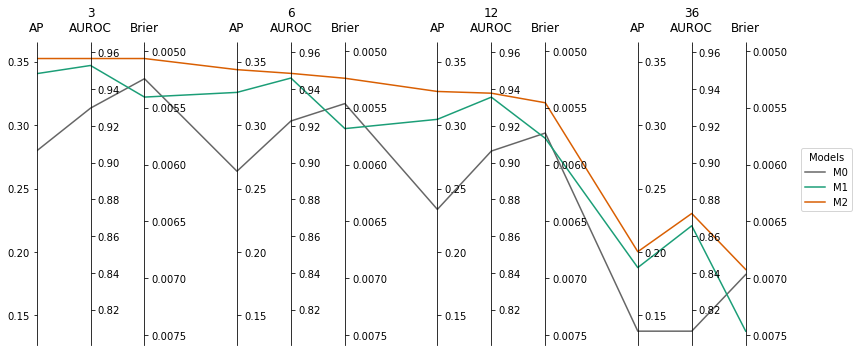

In [84]:
# Make coordinate plots
dfs_coords = pd.read_csv(os.path.join(output_paths['scores_tables'], f"eval_all_{run_outcome}_{calib_eval}_1110.csv"),index_col=[0],header=[0,1], skipinitialspace=True)
dfs_coords_copy = dfs_coords.swaplevel(axis=1)
dfs_coords_copy = dfs_coords_copy.reindex([('3', 'AP'),
 ('3', 'AUROC'),
 ('3', 'Brier'),
 ('6', 'AP'),
 ('6', 'AUROC'),
 ('6', 'Brier'),
 ('12', 'AP'),
 ('12', 'AUROC'),
 ('12', 'Brier'),
 ('36', 'AP'),
 ('36', 'AUROC'),
 ('36', 'Brier')], axis=1)
dfs_coords_copy = dfs_coords_copy[dfs_coords_copy.index.isin(['M0','M1','M2'])]

evaltools.plot_parcoord_allsteps(
    df = dfs_coords_copy,
    steps = ['3','6','12','36'],
    reverse = True,
    cmap='Dark2',
    legend_label=['M0','M1','M2',],
    path = os.path.join(output_paths["coord_plots"], f"coord_simple_{run_outcome}_{calib_eval}_1110_nd.png")
)

### Boostrapping

In [104]:
# Define parameters. 
calib = calib_eval
incidence = True
standardperiod = True

# Make list of all model names
all_model_names = []
for model in ModelList:
    all_model_names.append(model['modelname'])

# Select models.
coord_models_names = []
matchers = [
    'protest_baseline_simple_incidence',
    'protest_pr_naive_bl_incidence',
    'protest_pr_dynamic_loc_bl_incidence',
    'protest_pr_dynamic_nat_bl_incidence',
    'protest_inst_elecdemo_bl_incidence',
    'protest_pr_elecdemo_bl_incidence',
    'protest_inst_civlib_bl_incidence',
    'protest_pr_civlib_bl_incidence',
    'protest_inst_elect_bl_incidence',
    'protest_pr_elect_bl_incidence',
    'protest_inst_devi_bl_incidence',
    'protest_pr_devi_bl_incidence',
    'protest_econ_nat_bl_incidence',
    'protest_pr_econ_nat_bl_incidence',
    'protest_econ_full_bl_incidence',
    'protest_pr_econ_full_bl_incidence'
]

coord_models_names = [s for s in all_model_names if any(xs in s for xs in matchers)]

models_to_boot = []
for model in ModelList:
    if model['modelname'] in coord_models_names:
        models_to_boot.append(model)

if incidence:
    if standardperiod:
        name = f"mainmodels_incidence_ln"
    else:
        name = f"mainmodels_incidence_ln_np"  

else:
    if standardperiod:
        name = f"mainmodels_onset_ln"
    else:
        name = f"mainmodels_onset_ln_np"
print(name)
    
eval_fun = 'average_precision'
steps = steps

dfs_boots=[]
for model_to_boot in models_to_boot:
    print(model_to_boot['modelname'])
    for step in steps:
        print(step)
        df_boots = evaltools.boot_evalmetric(
            model = model_to_boot,
            step=step,
            eval_fun = eval_fun,
            calib = calib,
            set_seed = 1308,
            n_bootstraps=1000,
        )

        dfs_boots.append(df_boots)

df_boots_all = pd.concat(dfs_boots,axis=1) 
df_boots_all.to_csv(os.path.join(output_paths["bootstrapped"], f"boots_ap_{name}_{calib}.csv"))
print('df written to', f"boots_ap_{name}_{calib}.csv")

mainmodels_incidence_ln
protest_baseline_simple_incidence
3
6
12
36
protest_econ_nat_bl_incidence
3
6
12
36
protest_econ_full_bl_incidence
3
6
12
36
protest_inst_elecdemo_bl_incidence
3
6
12
36
protest_inst_civlib_bl_incidence
3
6
12
36
protest_inst_elect_bl_incidence
3
6
12
36
protest_inst_devi_bl_incidence
3
6
12
36
protest_pr_naive_bl_incidence
3
6
12
36
protest_pr_dynamic_loc_bl_incidence
3
6
12
36
protest_pr_dynamic_nat_bl_incidence
3
6
12
36
protest_pr_elecdemo_bl_incidence
3
6
12
36
protest_pr_civlib_bl_incidence
3
6
12
36
protest_pr_elect_bl_incidence
3
6
12
36
protest_pr_devi_bl_incidence
3
6
12
36
protest_pr_econ_nat_bl_incidence
3
6
12
36
protest_pr_econ_full_bl_incidence
3
6
12
36
df written to boots_ap_mainmodels_incidence_ln_nc.csv


In [114]:
# Define parameters.

titles = [
    'M1 vs M0',
    'M2 vs M1',
    'M3 vs M1',
    'M2 vs M0',
    'M3 vs M0',
    'M4 vs M2',
    'M5 vs M2',
    'M6 vs M2',
    'M7 vs M2',
    'M8 vs M2',
    'M9 vs M2',
    'M4 vs M4 w/o pr ',
    'M5 vs M5 w/o pr',
    'M6 vs M6 w/o pr',
    'M7 vs M7 w/o pr',
    'M8 vs M8 w/o pr',
    'M9 vs M9 w/o pr',

]

model1 =[
    f'protest_pr_naive_bl_incidence_average_precision_', #M1
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', #M2
    f'protest_pr_dynamic_nat_bl_incidence_average_precision_', # M3
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', #M2
    f'protest_pr_dynamic_nat_bl_incidence_average_precision_', # M3
    f'protest_pr_elecdemo_bl_incidence_average_precision_', #M4
    f'protest_pr_civlib_bl_incidence_average_precision_', #M5
    f'protest_pr_elect_bl_incidence_average_precision_', #M6
    f'protest_pr_devi_bl_incidence_average_precision_', #M7
    f'protest_pr_econ_nat_bl_incidence_average_precision_', #M8
    f'protest_pr_econ_full_bl_incidence_average_precision_', #M9
    f'protest_pr_elecdemo_bl_incidence_average_precision_', #M4
    f'protest_pr_civlib_bl_incidence_average_precision_', #M5
    f'protest_pr_elect_bl_incidence_average_precision_', #M6
    f'protest_pr_devi_bl_incidence_average_precision_', #M7
    f'protest_pr_econ_nat_bl_incidence_average_precision_',
    f'protest_pr_econ_full_bl_incidence_average_precision_',
    

]

model2 = [
    f'protest_baseline_simple_incidence_average_precision_', # M0
    f'protest_pr_naive_bl_incidence_average_precision_', #M1
    f'protest_pr_naive_bl_incidence_average_precision_', #M1
    f'protest_baseline_simple_incidence_average_precision_', # M0
    f'protest_baseline_simple_incidence_average_precision_', # M0
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_pr_dynamic_loc_bl_incidence_average_precision_', # M2
    f'protest_inst_elecdemo_bl_incidence_average_precision_', #M4 wo pr
    f'protest_inst_civlib_bl_incidence_average_precision_',
    f'protest_inst_elect_bl_incidence_average_precision_',
    f'protest_inst_devi_bl_incidence_average_precision_',
    f'protest_econ_nat_bl_incidence_average_precision_',
    f'protest_econ_full_bl_incidence_average_precision_',  
]

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


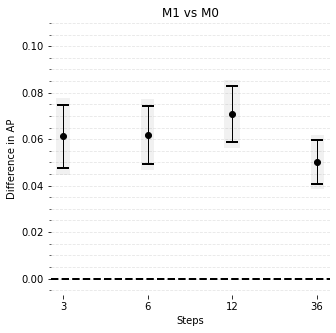

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

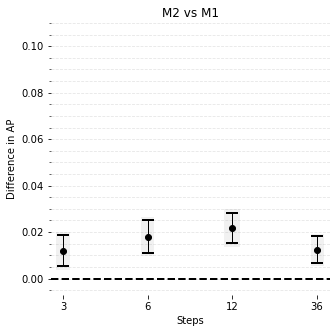

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

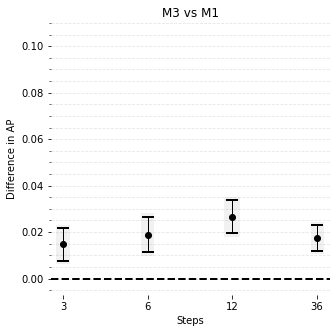

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

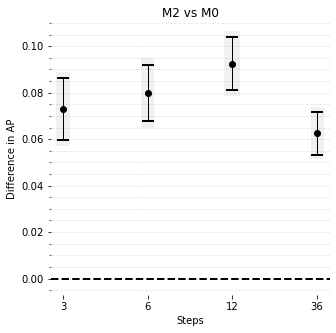

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

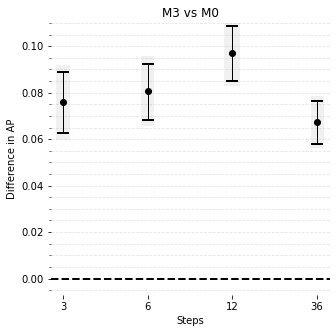

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

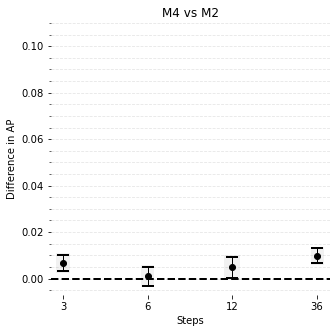

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

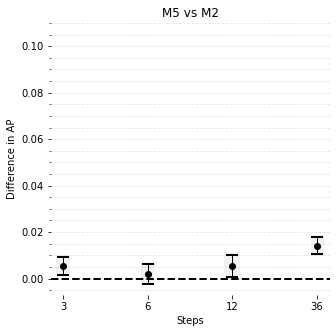

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

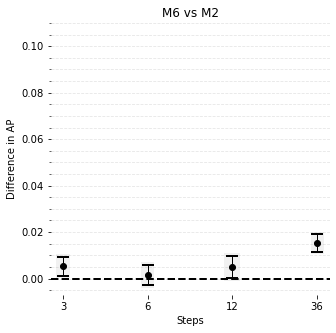

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

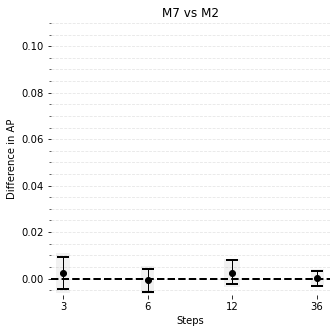

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

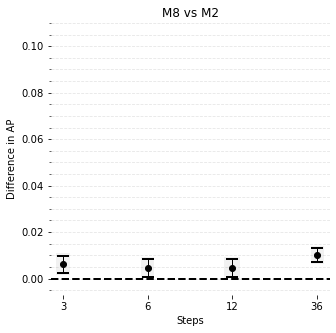

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

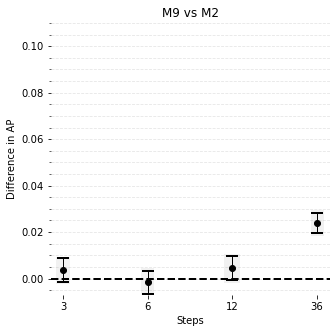

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

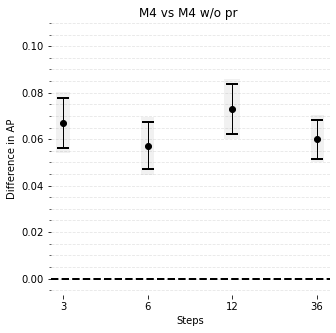

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

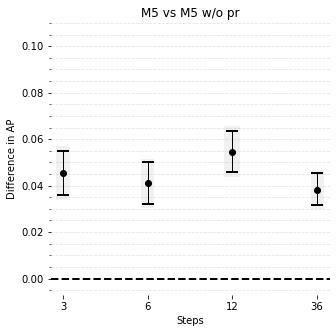

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

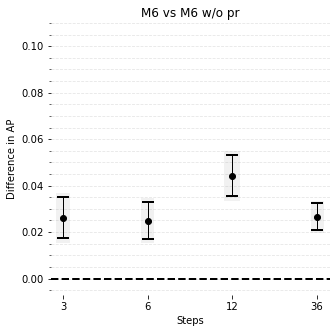

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

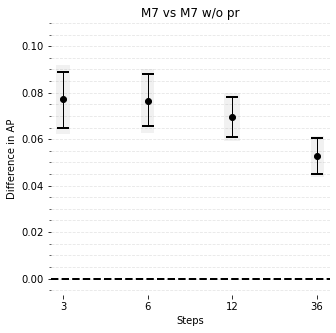

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

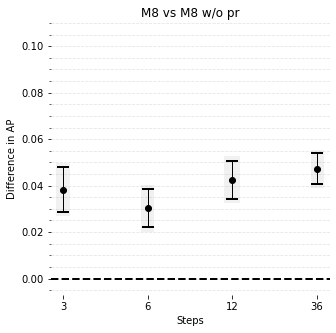

/Users/maxle647/Views3/predicting_armed_conflict_using_protest_data_eval.py:337: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

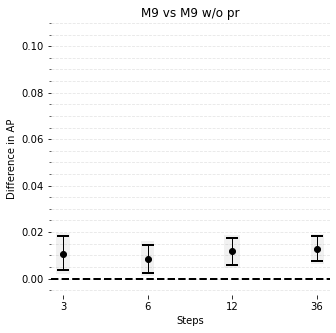

<Figure size 432x288 with 0 Axes>

In [150]:
# Define parameters.
legendtrue = False

ymin = -0.007
ymax = 0.11

evaltools.plot_bootstrapped_diff(
    df=df_boots_all,
    titles=titles,
    modellist1=model1,
    modelllist2=model2,
    legendtrue=legendtrue,
    steps=steps,
    ymin=ymin,
    ymax=ymax,
    path_out=os.path.join(output_paths["bootstrapped"], 
                          f"boot_ap_{t.replace(' vs ','_').replace(' w/o ', 'wo')}_incidence_mainmodels.png")
)